# Anatomical receptive field analysis

#### Analysis and visualization pipeline:

1. Loading pre- and postsynaptic cell type curated data sets
2. Matching all presynaptic cell ids connecting to each postsynaptic cell
3. Analysis of spatial span of presynaptic inputs to unique postsynaptic cells
4. Plotting value distributions of (3)
5. Colorcoding (3) for every postsynaptic cell column on top of the medulla neuropile mesh
6. Heatmaps of (3) to explore the data and catch some extrem values

In [96]:
#Importing packages

import os
import pandas as pd
import numpy as np
import seaborn as sns
from fafbseg import flywire
from caveclient import CAVEclient
client = CAVEclient('flywire_fafb_production')
from openpyxl import load_workbook
from synapse_queries_helper import combine_xyz
import navis
import matplotlib.pyplot as plt

### 1. Loading curated data sets

In [19]:
#Loading information  from excel files
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Excels\drive-data-sets'
date = '20230912'
fileName_post = f'Tm9 proofreadings_{date}.xlsx'
filePath_post = os.path.join(dataPath,fileName_post)
fileName_pre = f'Dm12 proofreadings_{date}.xlsx'
filePath_pre = os.path.join(dataPath,fileName_pre)

#Loading file as DataFrame
post_df = pd.read_excel(filePath_post)
pre_df = pd.read_excel(filePath_pre)


In [20]:
# Filtering data

# Selecting the R optic lobe IDs
R_pre_df = pre_df[pre_df['hemisphere'] == 'R'].copy()
R_post_df = post_df[post_df['hemisphere'] == 'R'].copy()

# Selecting the backbone proofread IDs
R_post_df = R_post_df[R_post_df['backbone proofread (Y/N)'] == 'Y'].copy()

# Selecting presynaptic cells ids
pre_ids = R_pre_df['Updated_seg_id'].tolist()


In [21]:
# Visualize the final data sets
display(R_post_df.head()) # tail or head is fine
display(R_pre_df.tail()) # tail or head is fine

,XYZ-ME,symbol,XYZ-LO,quality comment,hemisphere,lab,author,name,seg_id,identified_in,...,patch_id,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N),dorso-ventral
693,"190086.0,85837.0,3281.0",Tm9,"173170.0,78482.0,4592.0",NaN,R,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_L, transmedullary neuron Tm9, FBbt_00...",720575940627187849,"Fischbach & Dittrich, 1989",...,NaN,NaN,Y,N,Y,NaN,NaN,Y,N,V
694,"195500.0,50706.0,3987.0",Tm9,"181888.0,53114.0,5025.0",NaN,R,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_L, transmedullary neuron Tm9, FBbt_00...",720575940633362131,"Fischbach & Dittrich, 1989",...,NaN,NaN,Y,N,N,NaN,NaN,Y,N,D
695,"195267.0,48669.0,3884.0",Tm9,"181672.0,51656.0,5034.0",NaN,R,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_L, transmedullary neuron Tm9, FBbt_00...",720575940612657522,"Fischbach & Dittrich, 1989",...,NaN,NaN,Y,N,Y,NaN,NaN,N,N,D
696,"199314.0,68960.0,3401.0",Tm9,"181158.0,66070.0,4835.0",NaN,R,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_L, transmedullary neuron Tm9, FBbt_00...",720575940618481733,"Fischbach & Dittrich, 1989",...,NaN,NaN,Y,N,Y,NaN,NaN,Y,N,D
697,"202562.0,57002.0,4241.0",Tm9,"184741.0,57224.0,4775.0",NaN,R,Axel Borst Lab,Amalia Braun,"Tm9, Tm9_L, transmedullary neuron Tm9, Choline...",720575940629750844,"Fischbach & Dittrich, 1989",...,NaN,NaN,Y,N,N,NaN,NaN,Y,N,D


,XYZ-ME,symbol,XYZ-LO,quality comment,total_presynaptic_sites,hemisphere,lab,author,name,seg_id,...,optic_lobe_id,patch_id,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N)
209,NaN,Dm12,NaN,NaN,NaN,R,NaN,NaN,NaN,720575940646209059,...,Dm12-R106,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN
210,NaN,Dm12,NaN,NaN,NaN,R,NaN,NaN,NaN,720575940623783437,...,Dm12-R107,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
211,NaN,Dm12,NaN,NaN,NaN,R,NaN,NaN,NaN,720575940634292119,...,Dm12-R108,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,Dm12,NaN,NaN,NaN,R,NaN,NaN,NaN,720575940633203852,...,Dm12-R109,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN
213,NaN,Dm12,NaN,NaN,NaN,R,NaN,NaN,NaN,720575940618595874,...,Dm12-R110,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Matching all presynaptic cell ids connecting to each postsynaptic cell

In [22]:
# Updating presynaptic neurons if they are not up-to-date
if not np.unique(flywire.is_latest_root(pre_ids))[0]: #if not up-to-date
    update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    up_to_date_pre_ids = update_df['new_id'].tolist()
    display(update_df[update_df['changed'] == True])
    if len(update_df[update_df['confidence']< 1]) == 0:
        print('Good to go and match ids in the next step')
    else:
        print('Consider updating your ids in the original data set')
else:
    up_to_date_pre_ids = pre_ids
    


Updating:   0%|          | 0/110 [00:00<?, ?it/s]

,old_id,new_id,confidence,changed
46,720575940629488646,720575940615956118,1,True
55,720575940622687220,720575940630032144,1,True


Good to go and match ids in the next step


In [157]:
np.unique(flywire.is_latest_root(pre_ids))[0]

False

In [23]:
## Getting postsynaptic side ID
post_ls = R_post_df['Updated_seg_id'].tolist()

## Getting all synaptic connections

# Quick update
if not np.unique(flywire.is_latest_root(post_ls))[0]: # if not up-to-date
    #Updating the IDs via Fafbseg
    update_df = flywire.update_ids(post_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    post_ls = update_df['new_id']
    display(update_df[update_df['confidence'] < 1])
    

# Fetch the neuron's inputs
post_inputs = flywire.synapses.fetch_synapses(post_ls, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

# Filter connections just selected presynaptic cells
pre_post_match_df = post_inputs[post_inputs['pre'].isin(up_to_date_pre_ids)].copy()
display(pre_post_match_df.head())


Updating:   0%|          | 0/576 [00:00<?, ?it/s]

,old_id,new_id,confidence,changed


Fetching synapses:   0%|          | 0/20 [00:00<?, ?it/s]

,pre,post,cleft_score,pre_x,pre_y,pre_z,post_x,post_y,post_z,id,neuropil
14,720575940624077005,720575940626579087,155,714384,331676,109080,714288,331716,109080,221908202,ME_L
76,720575940623345878,720575940659650945,142,778372,365500,169480,778256,365536,169480,5228051,ME_L
77,720575940623345878,720575940659650945,145,778368,365496,169520,778212,365528,169560,5228061,ME_L
84,720575940633432659,720575940630963275,143,767804,226416,125000,767796,226500,124960,77624730,ME_L
291,720575940632751928,720575940627342408,136,781400,352268,157200,781416,352136,157160,240226604,ME_L


### 3. Analysis of spatial span of presynaptic inputs to unique postsynaptic cells

In [24]:
# Aggregating data frame based on unique post and pre segment IDs
# While aggregating, counting the number of contacts for each pre-post pair

pre_post_counts = pre_post_match_df.groupby(['post', 'pre'])['pre'].count().reset_index(name='pre_count')

In [160]:
# Synaptic counts filter (relevant for ur syn >= 3)
min_desired_count = 3
pre_post_counts = pre_post_counts[pre_post_counts['pre_count']>=min_desired_count].copy()
display(pre_post_counts)

,post,pre,pre_count
0,720575940600084489,720575940620506704,3
1,720575940600084489,720575940622432895,3
2,720575940600084489,720575940631099708,8
3,720575940603557920,720575940610422467,6
4,720575940603557920,720575940616104863,3
...,...,...,...
1080,720575940650399097,720575940614602415,11
1082,720575940652963830,720575940613296370,7
1085,720575940655683489,720575940618380518,3
1087,720575940659627137,720575940619054676,5


In [25]:
## Geeting information for all pre cells 
pre_ls = pre_post_counts['pre'].tolist() # all postsynaptic neurons

# Fetch the inputs from presynaptic cells
pre_inputs = flywire.synapses.fetch_synapses(pre_ls, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")


Fetching synapses:   0%|          | 0/37 [00:00<?, ?it/s]

In [27]:
#Combining pre- and postsynpases XYZ values in single columns

display(pre_inputs.head()) # Before operation
combine_xyz(pre_inputs) # Function that does the operation
display(pre_inputs.head()) # After operation

,pre_pt_root_id,post_pt_root_id,cleft_score,pre_x,pre_y,pre_z,post_x,post_y,post_z,id,neuropil,post_pt_position,pre_pt_position
0,720575940632683660,720575940623345878,167,769988,365212,163920,769872,365164,163960,88333356,ME_L,"[192468.0, 91291.0, 4099.0]","[192497.0, 91303.0, 4098.0]"
1,720575940613668713,720575940622451188,145,788268,364508,198720,788408,364476,198720,1901386,ME_L,"[197102.0, 91119.0, 4968.0]","[197067.0, 91127.0, 4968.0]"
4,720575940617547547,720575940627971709,66,760808,287032,125760,760980,287056,125720,77287247,ME_L,"[190245.0, 71764.0, 3143.0]","[190202.0, 71758.0, 3144.0]"
6,720575940646051716,720575940631099708,144,812172,290392,157040,812128,290268,157000,240409999,ME_L,"[203032.0, 72567.0, 3925.0]","[203043.0, 72598.0, 3926.0]"
7,720575940613833842,720575940631099708,150,802032,307456,149080,802144,307500,149080,70708507,ME_L,"[200536.0, 76875.0, 3727.0]","[200508.0, 76864.0, 3727.0]"


,pre_pt_root_id,post_pt_root_id,cleft_score,pre_x,pre_y,pre_z,post_x,post_y,post_z,id,neuropil,post_pt_position,pre_pt_position
0,720575940632683660,720575940623345878,167,769988,365212,163920,769872,365164,163960,88333356,ME_L,"[192468.0, 91291.0, 4099.0]","[192497.0, 91303.0, 4098.0]"
1,720575940613668713,720575940622451188,145,788268,364508,198720,788408,364476,198720,1901386,ME_L,"[197102.0, 91119.0, 4968.0]","[197067.0, 91127.0, 4968.0]"
4,720575940617547547,720575940627971709,66,760808,287032,125760,760980,287056,125720,77287247,ME_L,"[190245.0, 71764.0, 3143.0]","[190202.0, 71758.0, 3144.0]"
6,720575940646051716,720575940631099708,144,812172,290392,157040,812128,290268,157000,240409999,ME_L,"[203032.0, 72567.0, 3925.0]","[203043.0, 72598.0, 3926.0]"
7,720575940613833842,720575940631099708,150,802032,307456,149080,802144,307500,149080,70708507,ME_L,"[200536.0, 76875.0, 3727.0]","[200508.0, 76864.0, 3727.0]"


In [284]:
#Quantification of spatial span

pre_post_volumnes = []
for i in range(0,len(post_ls)):

    #i = 0 # TODO: Looping across individual postsynaptic cells
    curr_post = post_ls[i] 
    #display(pre_post_counts[pre_post_counts['post'] == curr_post])

    curr_pre_ls = pre_post_counts[pre_post_counts['post'] == curr_post]['pre'].tolist() # single postsynaptic neuron candidate
    curr_pre_inputs = pre_inputs[pre_inputs['post_pt_root_id'].isin(curr_pre_ls)].copy() # here 'post' in the pre_inputs dataframe are our candidate presynapic cells

    if len(curr_pre_inputs) == 0: # if the postsynaptic neuron do not contact any presynaptic one
        pre_post_volumnes.append(0)
    
    else:
    
        # Getting presynaptic cells coordinates
        coords = curr_pre_inputs['pre_pt_position'].tolist()
        pre_xyz = np.array([list(np.array(l)*[4,4,40]) for l in coords])

        # Calculate the center of the cloud of points
        pre_center = np.mean(pre_xyz, axis=0)

        # Calculate the volume of the cloud using the convex hull method
        from scipy.spatial import ConvexHull
        hull = ConvexHull(pre_xyz)
        volume = hull.volume
        pre_post_volumnes.append(volume)

        # Getting postynaptic cells coordinates
        old_curr_post = update_df[update_df['new_id'] == curr_post]['old_id'][i]
        post_coords = R_post_df[R_post_df['Updated_seg_id'] == old_curr_post]['XYZ-ME'].to_numpy(dtype=str, copy=True)
        post_xyz = np.zeros([np.shape(post_coords)[0],3])
        for idx, coordinate in enumerate(post_coords):
            post_xyz[idx,:] = np.array([coordinate.split(',')],dtype=float)
        post_xyz *=[4,4,40] # For plotting it using navis

        # Calculate the vector from the single point to the center of the cloud
        vector_to_center = pre_center - post_xyz
        #vector_to_center *= 10


# Summury data frame
spatial_span_df = pd.DataFrame()
spatial_span_df['bodyId_post'] = post_ls
spatial_span_df['Volume'] = pre_post_volumnes

Text(0.5, 0, 'Presynaptic cells volume')

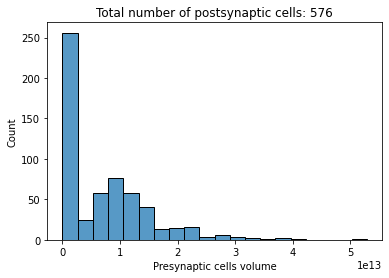

In [283]:
# Brief data distribution visualization
sns.histplot(pre_post_volumnes)
plt.title(f'Total number of postsynaptic cells: {len(post_ls)}')
plt.ylabel('Count')
plt.xlabel('Presynaptic cells volume')

In [290]:
# Neurons that do not receive inputs from any presynaptic cell type

spatial_span_df[spatial_span_df['Volume'] != 0]['bodyId_post'].tolist()

[720575940627187849,
 720575940612657522,
 720575940625889155,
 720575940610056654,
 720575940630186571,
 720575940659650945,
 720575940628721307,
 720575940624447015,
 720575940642642996,
 720575940642871604,
 720575940630963275,
 720575940627342408,
 720575940626985482,
 720575940625769418,
 720575940608295433,
 720575940633269971,
 720575940637612429,
 720575940619784545,
 720575940626513173,
 720575940637255821,
 720575940638358643,
 720575940632804453,
 720575940608983235,
 720575940631324985,
 720575940640432848,
 720575940616591755,
 720575940622199688,
 720575940632213646,
 720575940640152448,
 720575940620680277,
 720575940645555252,
 720575940644367396,
 720575940639044942,
 720575940612630130,
 720575940635858544,
 720575940637550221,
 720575940640435152,
 720575940633285739,
 720575940623305107,
 720575940620030633,
 720575940638320256,
 720575940624434320,
 720575940631777676,
 720575940610175381,
 720575940612896682,
 720575940628906795,
 720575940641658676,
 720575940639

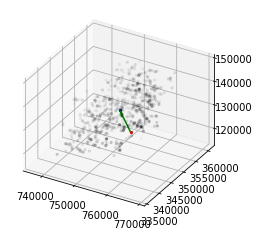

In [264]:
# Brief visualization
hemisphere = 'R' # 'R', 'L'
neurpile_mesh = 'ME_L'
mesh_azim = 16# -18 for ME_R, 16 for ME_L
mesh_elev = -50 # -148 for ME_R, -50 for ME_L

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(post_xyz[:,0],post_xyz[:,1],post_xyz[:,2],'.',color=[1,0,0], s = 5) # Location of postsynaptic cell
ax.scatter(pre_center[0],pre_center[1],pre_center[2],'.',color=[0,0,1], s = 5) # Location of center of cloud of presynaptic cells
ax.scatter(pre_xyz[:,0],pre_xyz[:,1],pre_xyz[:,2],'.',color=[0,0,0,0.1], s = 5) # Cloud

# Plot the vector as an arrow
ax.quiver(post_xyz[0, 0], post_xyz[0, 1], post_xyz[0, 2],
          vector_to_center[:,0], vector_to_center[:,1], vector_to_center[:,2],
          color='g', label='Vector to Center')



#OL_R = flywire.get_neuropil_volumes([neurpile_mesh]) 
#navis.plot2d([OL_R], method='3d_complex', ax=ax) # scalebar = '20 um'

#ax.azim = mesh_azim
#ax.elev = mesh_elev

#### Attemps to project the 3D cloud into a 2D plane.

In [ ]:
## Projecting to a 2D plane

# Normalize the vector_to_center to define the normal vector of the plane
normal_vector = vector_to_center / np.linalg.norm(vector_to_center)

# Calculate the projection of all cloud points onto the plane
projections = np.dot(pre_xyz - post_xyz, np.squeeze(normal_vector))

# Calculate the projected points
projected_pre_xyz = pre_xyz - projections[:, np.newaxis] * normal_vector

# Calculate the projection of the center onto the plane
projected_pre_center = pre_center - np.dot(pre_center - post_xyz, np.squeeze(normal_vector)) * normal_vector

# Calculate the projection of the postsynaptic cell
projected_post_xyz = post_xyz - np.dot(post_xyz - post_xyz, np.squeeze(normal_vector)) * normal_vector

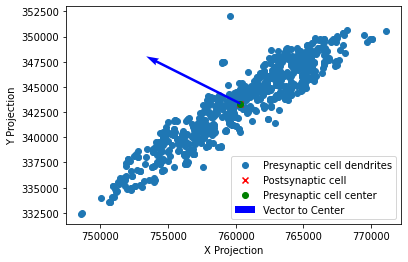

In [256]:
# Create a 2D scatter plot of the projected points
plt.scatter(projected_pre_xyz[:, 0], projected_pre_xyz[:, 1], label='Presynaptic cell dendrites')
plt.scatter(projected_post_xyz[:, 0], projected_post_xyz[:,1], c='r', marker='x', label='Postsynaptic cell')
plt.scatter(projected_pre_center[:,0], projected_pre_center[:,1], c='g', marker='o', label='Presynaptic cell center')

# Plot the vector_to_center as an arrow
plt.quiver(projected_post_xyz[:,0], projected_post_xyz[:,1],
           vector_to_center[:,0], vector_to_center[:,1],
           angles='xy', scale_units='xy', scale=1, color='b', label='Vector to Center')

# Set axis labels
plt.xlabel('X Projection')
plt.ylabel('Y Projection')

# Set legend
plt.legend()

# Show the plot
plt.show()

ValueError: x and y must be the same size

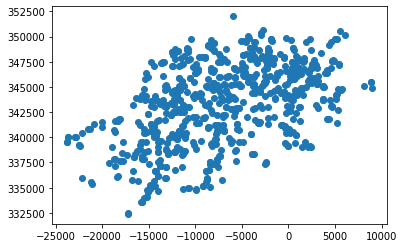

In [259]:
## Testing another plane:

# Calculate the new 2D plane's normal vector
new_normal_vector = np.array([1.0, 0.0, 0.0])  # Example: A plane perpendicular to the X-axis

# Calculate the projection of the points onto the new 2D plane
projection_magnitude = np.dot(pre_xyz - post_xyz, new_normal_vector)

# Create a 2D scatter plot of the projected points onto the new 2D plane
plt.scatter(projection_magnitude, projected_pre_xyz[:, 1], label='Presynaptic cell dendrites')
plt.scatter(projection_magnitude, projected_post_xyz[:, 1], c='r', marker='x', label='Postsynaptic cell')
plt.scatter(projection_magnitude, projected_pre_center[:, 1], c='g', marker='o', label='Presynaptic cell center')

# Plot the projection of the vector_to_center as a single dot in the new 2D plane
plt.scatter(0, 0, c='b', marker='o', label='Projected Vector to Center')

# Set axis labels
plt.xlabel('X Projection (New Plane)')
plt.ylabel('Y Projection')

# Set legend
plt.legend()

# Show the plot
plt.show()

In [184]:
volume



8214102759039.997

In [189]:
vector_to_center[:,0]

array([-6951.69191919])

In [262]:
navis.plot3d([pre_xyz], color= [1,0,0]) # [0.5,0.5,0.5,0.1],[1,1,0],[1,0,1]]
navis.plot3d([OL_R], color= [0.5,0.5,0.5,0.1]) # [0.5,0.5,0.5,0.1],[1,1,0],[1,0,1]]